# Ham and Spam E-mail Classifier

Work performed by:
- Diogo Carvalho 92969
- Gil Viegas 99576
- Rafael Baptista 93367

# 1. Data Preprocessing

## 1.1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, recall_score, confusion_matrix, accuracy_score, precision_score, roc_auc_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#Disable warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1.2. DataSet Read
Read data from initial dataset

In [2]:
df = pd.read_csv("spambase/spambase.data", header=None)

In [3]:
# Get the labels of all examples
y = df[57]

# Convert data to numpy array
df_np = df.to_numpy()

## 1.3. Split dataset in Training Set and Test Set

Split dataset into Training Set and Test Set. This is a technique used for evaluating the performance of our models.
- Train set (70%): Used to fit the model.
- Test set (30%): Used to evaluate the model.

In [4]:
X = df_np[:,:57]  # Get a matrix with all examples without the label

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

# Split the data: 70% - training set; 30% - test set.
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3)

## 1.4. Dataset Display
To get a better understanding of our dataset we will visualize our data in different ways.
### 1.4.1. Histogram of samples distribution
In order to analyze our samples distribution we will plot an histogram to see if the data is balanced or not.

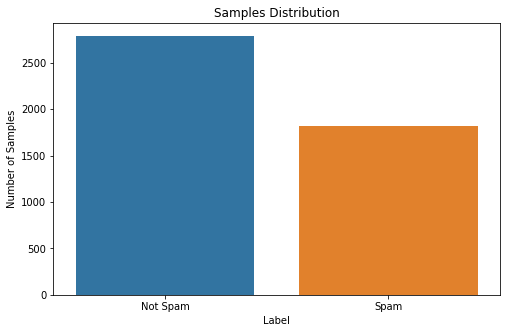

In [5]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(y)
plt.xlabel("Label")
ax.set_xticklabels(['Not Spam', 'Spam'])
plt.ylabel("Number of Samples")
plt.title("Samples Distribution")
plt.show()


### 1.4.2. Box plots of features
To analyze each feature of our dataset we will present a Box Plot for each one to see if the feature discriminates the two classes well.

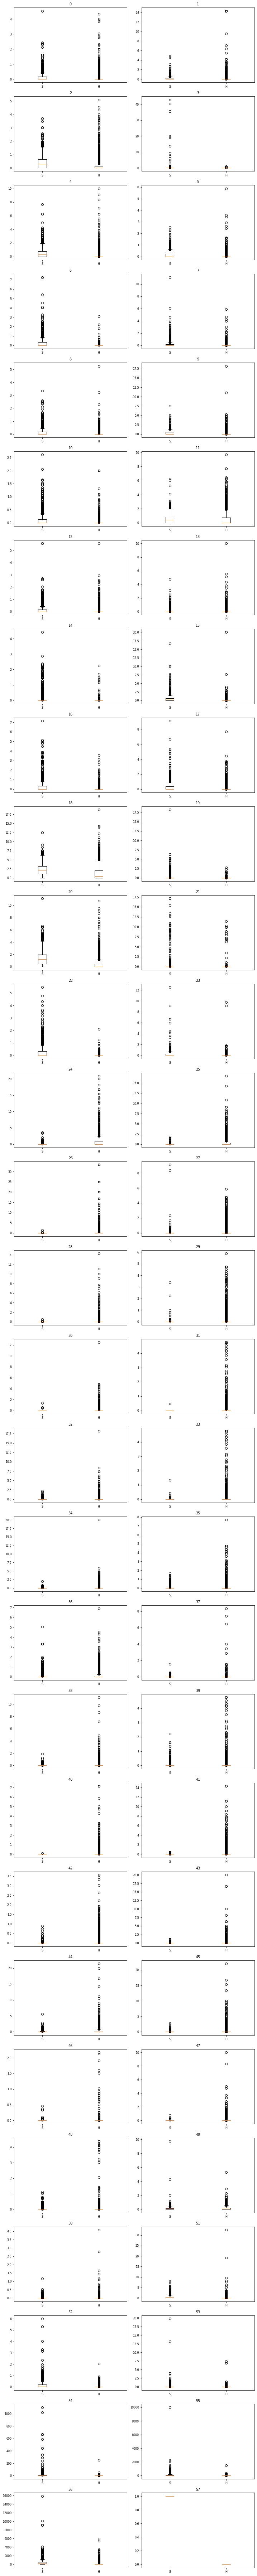

In [6]:
dfS=df[df[57] ==1]  # Spam examples
dfH=df[df[57] ==0]  # Not Spam examples

#Creating the window with 58 subplots.
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=29, ncols=2, figsize=(10,100))
axes = axes.ravel()
#BOXPLOTS
for idx,ax in enumerate(axes):
    ax.figure
    data_to_plot = [dfS[idx],dfH[idx]]
    ax.boxplot(data_to_plot)
    ax.set_xticklabels(['S', 'H'])
    ax.set_title(idx)
plt.tight_layout()
plt.show()    

### 1.4.3. Histograms for all features
With a similar goal to the previous step, we will know plot an histogram for each feature, to analyze if the feature discriminates the two labels well.

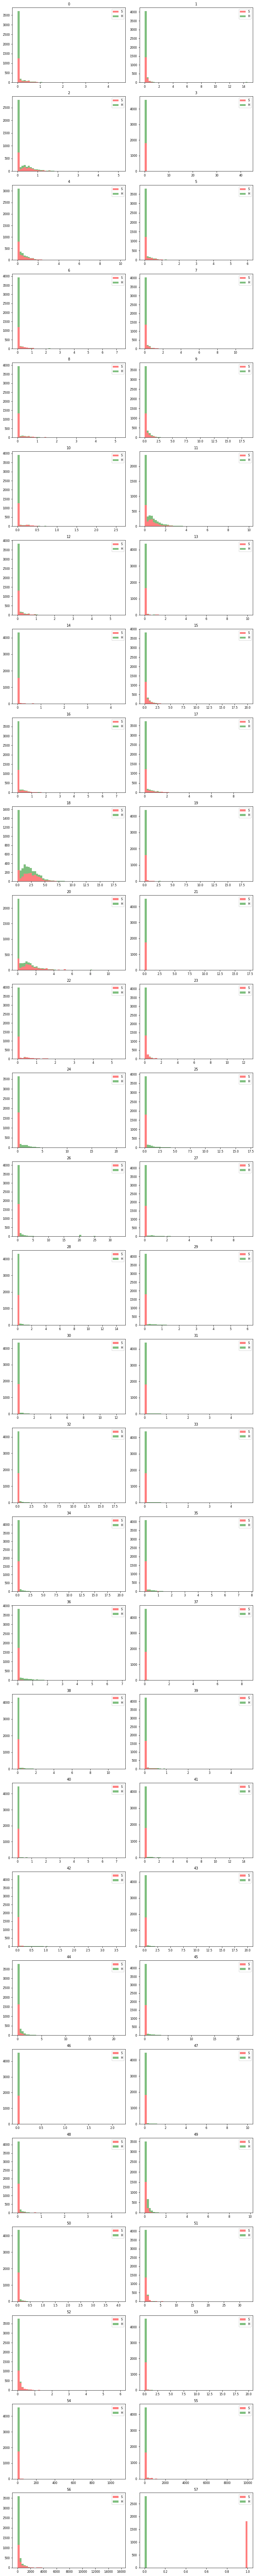

In [7]:
dfS=df[df[57] ==1]  # Spam examples
dfH=df[df[57] ==0]  # Not Spam examples

#Creating the window with 10 subplots.
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=29, ncols=2, figsize=(10,100))
axes = axes.ravel()
#Creating histograms with 50 bins
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[idx]) - min(df[idx]))/50
    ax.hist([dfS[idx],dfH[idx]], bins=np.arange(min(df[idx]), max(df[idx]) + binwidth, binwidth) , alpha=0.5,stacked=True, label=['S','H'],color=['r','g']) #remove density=True to remove probs in y axis
    ax.legend(loc='upper right')
    ax.set_title(idx)
plt.tight_layout()
plt.show()

## 1.5. Feature Selection
The feature selection is a technique used to remove some features that don't discriminate the two classes well from our dataset. This technique is advantageous because it will reduce the computational cost of fitting the model and, in some cases, improve the performance of the model.

We will now perform feature selection based on the F-score value. 
### 1.5.1. F-score calculation

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

N=57

k_bestfeatures = SelectKBest(score_func = f_classif)
rankings = k_bestfeatures.fit(X_train,y_train)
b=list(rankings.scores_)
a=list(range(0,len(b)))

sf = [g for _,g in sorted(zip(b,a))]
sf=sf[len(a)-N:len(a)]
c=1
sf=reversed(sf)
print(['order','index','f-score'])
inx=[]
for chosen in sf:
    print(str(c)+'º: ', chosen,'   ', b[chosen])
    c+=1
    inx.append(chosen)
print(inx)

['order', 'index', 'f-score']
1º:  20     540.0008303411921
2º:  22     365.12920180797823
3º:  6     347.11509659233997
4º:  55     330.17660582949196
5º:  52     325.80143431968764
6º:  16     262.60848354930704
7º:  24     238.0589731235808
8º:  56     226.0283618303554
9º:  18     221.3140276010243
10º:  15     205.04525554106084
11º:  25     191.29379348460256
12º:  8     185.79182801282656
13º:  5     183.78638781613952
14º:  4     170.7914569729251
15º:  7     166.22481004213304
16º:  10     164.7370574131472
17º:  51     161.79345071984056
18º:  19     159.82387303223683
19º:  23     150.32217374431536
20º:  2     130.1262241715597
21º:  17     120.36245960968796
22º:  14     117.67874411983105
23º:  36     110.35253921859501
24º:  26     108.295012387654
25º:  29     106.20873326946793
26º:  27     82.20089892559389
27º:  34     71.349299858811
28º:  9     65.62146168631891
29º:  45     63.16648290581133
30º:  42     63.124624171767714
31º:  44     62.936176143956885
32º:  12 

### 1.5.2. Scatter matrix of the top 10 features
In order to analyze the distribution of the examples between pairs of features, we will create a scatter matrix to analyze the pairs of the top 10 features based on the F-score calculation performed in the previous step.

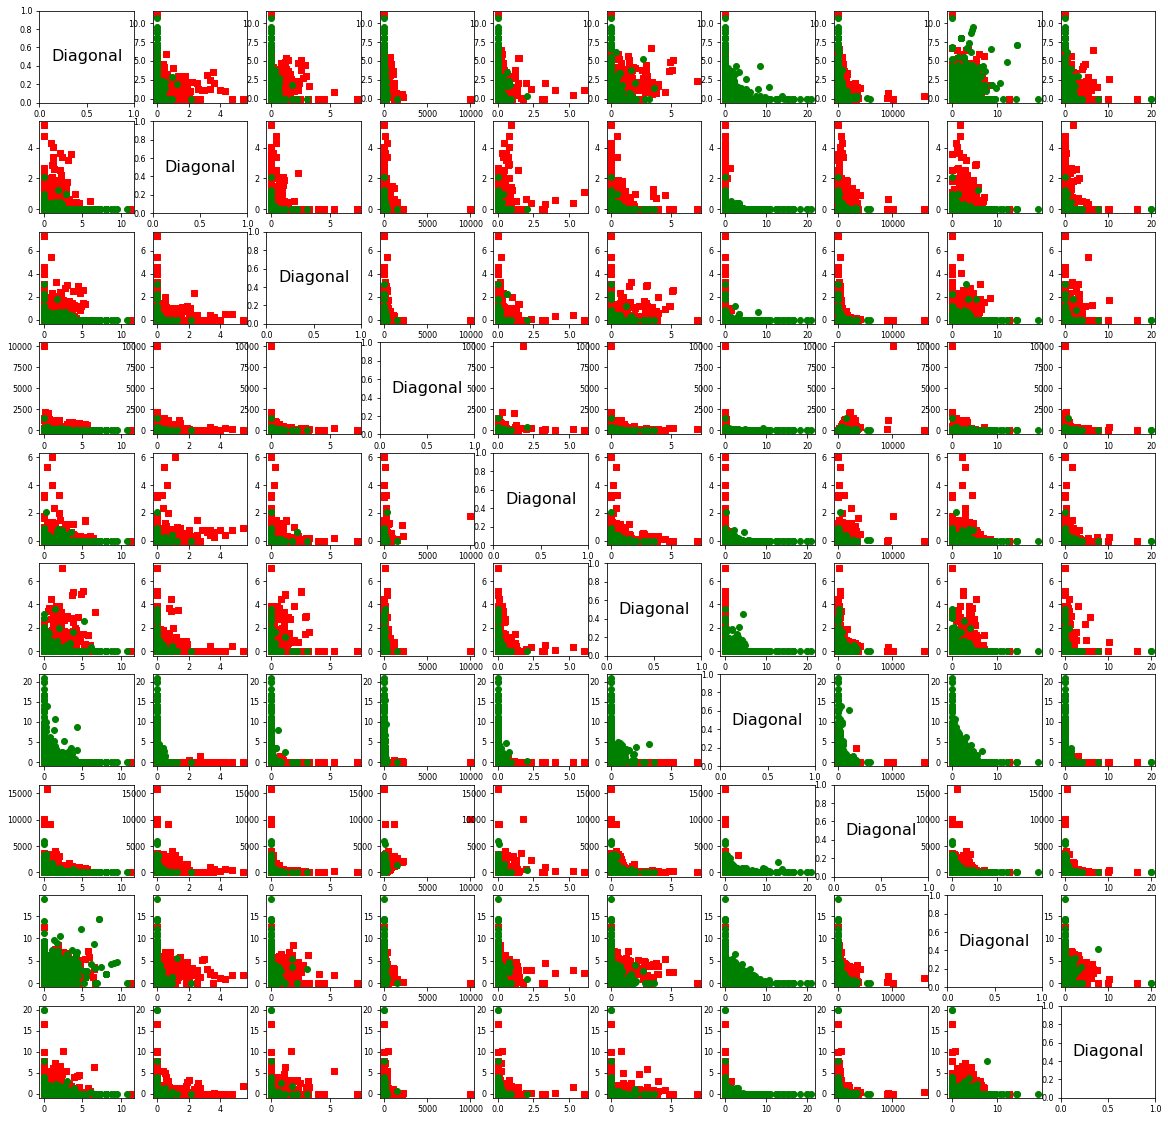

In [9]:
dfS=df[df[57] ==1]  # Spam examples
dfH=df[df[57] ==0]  # Not Spam examples

plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(20,20))

# Get the top 10 features ordered by F-score
top_10_features = inx[:10]

for i in range(10):
    for j in range(10):
        ax = axes[i,j]
        ax.figure
        if i == j:
            ax.text(0.5, 0.5, "Diagonal", transform=ax.transAxes,
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=16)
        else:
            ax.scatter(dfS[top_10_features[j]],dfS[top_10_features[i]],marker='s',color='r',label='S')
            ax.scatter(dfH[top_10_features[j]],dfH[top_10_features[i]],marker='o',color='g',label='H')    

plt.show()

### 1.5.3. Pearsons correlation values of pairs for all features 
The Pearson correlation value measures the strength of the linear relationship between two variables. I.e the closer this value is to 1, the greater is the correlation between the two features, and due to that we can remove one of the two features because they are very correlated.

In [10]:
# Matrix to store all pearsons correlations values
pearsons_correlations = np.empty([57, 57])

for i in range(0, df.shape[1]-1):
    for k in range(i+1, df.shape[1]-1):
        
        # Calculate Pearson's correlation between feature i and k
        corr, _ = pearsonr(df_np[:, i], df_np[:, k])
        
        # Store the value in matrix
        pearsons_correlations[i, k] = corr
        pearsons_correlations[k, i] = corr
        
        print("Pearsons correlation between {0} and {1}: {2}".format(i, k, corr))


Pearsons correlation between 0 and 1: -0.016759465965112526
Pearsons correlation between 0 and 2: 0.06562676741246644
Pearsons correlation between 0 and 3: 0.013273232168107524
Pearsons correlation between 0 and 4: 0.023118630601867165
Pearsons correlation between 0 and 5: 0.05967433812016053
Pearsons correlation between 0 and 6: 0.007668553072690656
Pearsons correlation between 0 and 7: -0.003949886838921879
Pearsons correlation between 0 and 8: 0.106262978895582
Pearsons correlation between 0 and 9: 0.04119770210863794
Pearsons correlation between 0 and 10: 0.1884586382769463
Pearsons correlation between 0 and 11: 0.10580100402791734
Pearsons correlation between 0 and 12: 0.06643817776869967
Pearsons correlation between 0 and 13: 0.03678048907348532
Pearsons correlation between 0 and 14: 0.02843879479885183
Pearsons correlation between 0 and 15: 0.05938565344264984
Pearsons correlation between 0 and 16: 0.08192807076096431
Pearsons correlation between 0 and 17: 0.0533235331746644
Pea

Pearsons correlation between 24 and 41: 0.01946855791127544
Pearsons correlation between 24 and 42: 0.11423677508095474
Pearsons correlation between 24 and 43: -0.0017172406596303905
Pearsons correlation between 24 and 44: 0.0496761210808588
Pearsons correlation between 24 and 45: -0.04591611443133619
Pearsons correlation between 24 and 46: 0.002627184285806939
Pearsons correlation between 24 and 47: -0.0027392906287321632
Pearsons correlation between 24 and 48: 0.029181252714712214
Pearsons correlation between 24 and 49: 0.13697916507421454
Pearsons correlation between 24 and 50: 0.03972274492733365
Pearsons correlation between 24 and 51: -0.09086161605765469
Pearsons correlation between 24 and 52: -0.08663403644338366
Pearsons correlation between 24 and 53: 0.0587797077881949
Pearsons correlation between 24 and 54: -0.017285315150573258
Pearsons correlation between 24 and 55: -0.051206381699510674
Pearsons correlation between 24 and 56: -0.04326743005366018
Pearsons correlation betwe

### 1.5.4. Pearsons correlation matrix of pairs for all features
To get a better idea of ​​the correlation values, we will present a correlation matrix with a color scale. The darker the color, the closer to 1 the correlation value will be.

(57, 57)


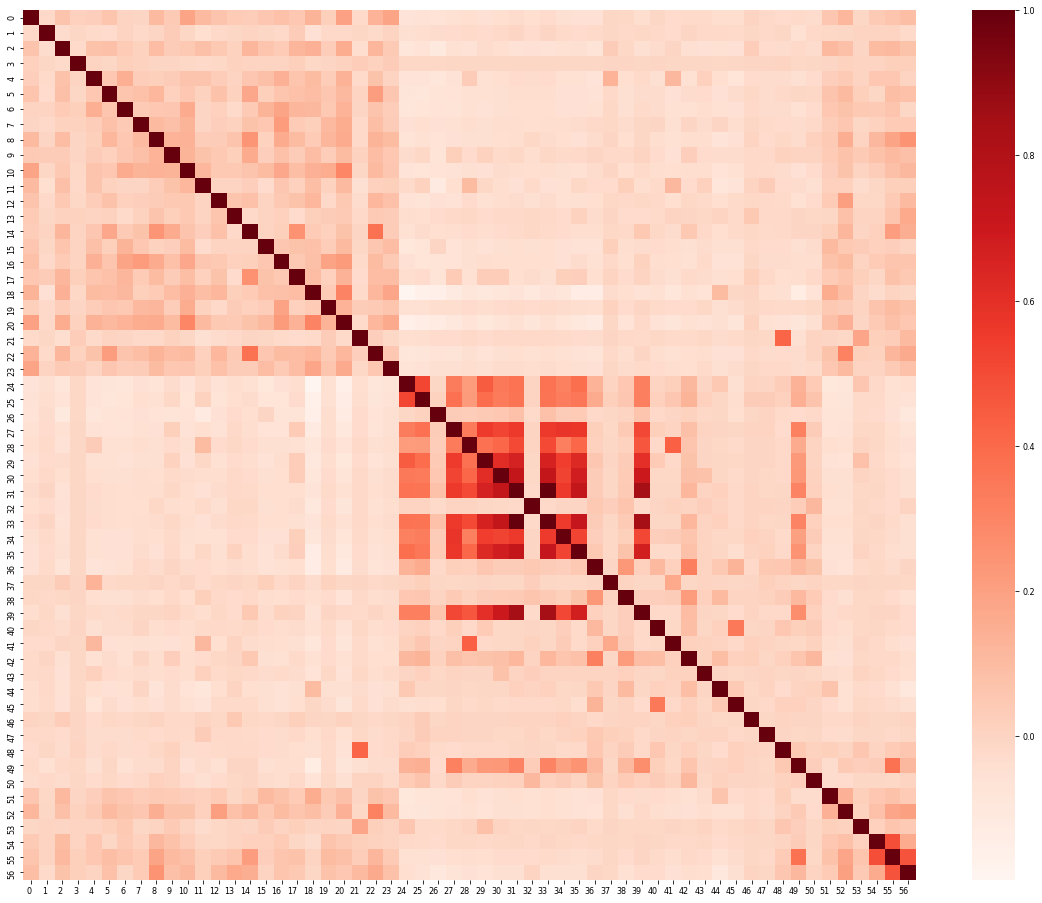

In [11]:
# Using numpy software.
corr = np.corrcoef(df_np[:, :-1].T)
print(corr.shape)

plt.figure(figsize=(20,16))

ax = sns.heatmap(corr, cmap=plt.cm.Reds)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=0,
    horizontalalignment='right'
);
plt.show()

### 1.5.5. Pearsons correlation matrix - Reduction of features
After calculating the F-score we will remove one feature of the pairs of features that are very correlated. For that we will use the pearsons correlation matrix. The feature of the pair that is removed is the one with a lower value of F-score. 
The threshold value we use to determine if a pair of features is very correlated is 0.8.

In [12]:
# Convert numpy to DataFrame
data_features = pd.DataFrame(X, dtype='float')

# Get correlation matrix
corr_matrix = data_features.corr().abs()

# Function to remove features
def remove_features(X_train, X_test, corr, threshold=0.8):
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    to_drop = []
    for column in upper.columns:
        other_column = 0
        for correlation_value in upper[column]:
            
            # If the correlation value between the two features is greater than the threshold
            if correlation_value > threshold:
                # Remove the feature that has the lower F-score or the other one if it is already going to be removed
                if inx.index(column) > inx.index(upper.columns[other_column] and other_column not in to_drop):
                    inx.remove(column)
                    to_drop.append(upper.columns[other_column])
                else:
                    inx.remove(column)
                    to_drop.append(column)
                break
            other_column += 1
    print("Removed features: ", to_drop)
    return X_train.drop(X_train[to_drop], axis=1), X_test.drop(X_test[to_drop], axis=1), to_drop

X_train, X_test, removed_features = remove_features(pd.DataFrame(X_train, dtype='float'), pd.DataFrame(X_test, dtype='float'), corr_matrix)
print(X_train.head())

Removed features:  [33, 39]
     0    1    2    3     4     5    6     7    8    9   ...   47   48     49  \
0  0.05  0.3  0.4  0.0  0.10  0.05  0.0  0.05  0.1  0.0  ...  0.0  0.0  0.036   
1  0.00  0.0  0.0  0.0  0.00  0.00  0.0  0.00  0.0  0.0  ...  0.0  0.0  0.000   
2  0.00  0.0  0.0  0.0  0.68  0.00  0.0  0.00  0.0  0.0  ...  0.0  0.0  0.143   
3  0.00  0.0  0.0  0.0  0.00  0.00  0.0  0.00  0.0  0.0  ...  0.0  0.0  0.350   
4  0.00  0.0  0.0  0.0  0.00  0.00  0.0  6.06  0.0  0.0  ...  0.0  0.0  0.000   

    50     51     52   53     54    55     56  
0  0.0  0.054  0.118  0.0  2.379  96.0  583.0  
1  0.0  0.000  0.000  0.0  1.235   5.0   21.0  
2  0.0  0.000  0.000  0.0  1.784  18.0  141.0  
3  0.0  0.000  0.000  0.0  1.461   6.0   19.0  
4  0.0  0.480  0.480  0.0  1.684  10.0   32.0  

[5 rows x 55 columns]


## 1.6. Feature Scaling
Feature Scaling is a method to normalize our data. Since we had features with values too small (between 0 and 1), and features with values too high comparing with the first ones, we performed a normalization process.
### 1.6.1. Normalization
Now we normalize all the dataset using a StandardScaler. The Standard Scaler performs this technique using this formula: 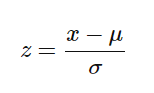

In [13]:
scaler = StandardScaler()

# Fit the scaler and transform the X_train set
scaled_features = scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(scaled_features, index=X_train.index, columns=X_train.columns)

# Transform only the X_test set using the scaler fitted with the X_train set
scaled_features = scaler.transform(X_test.values)
X_test = pd.DataFrame(scaled_features, index=X_test.index, columns=X_test.columns)

# 2. Train Model

In the section we will now train our models to study which parameters are better for each one. 
We will study the following classifiers:
 - SVM
 - Random Forest
 - Logistic Regression

## 2.1. SVM 
Support Vector Machine is one of the most used classifiers in ML. It is a classification method used in problems of supervised learning. It constructs a hyperplane in a high dimensional space that is used to predict the data in the different labels.

Degree:  1  C:  1  Max accuracy:  85.09
Degree:  2  C:  50  Max accuracy:  79.32
Degree:  3  C:  100  Max accuracy:  83.42


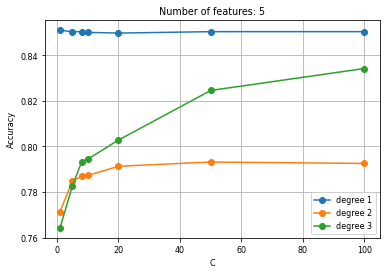

Degree:  1  C:  50  Max accuracy:  89.1
Degree:  2  C:  100  Max accuracy:  86.12
Degree:  3  C:  100  Max accuracy:  88.98


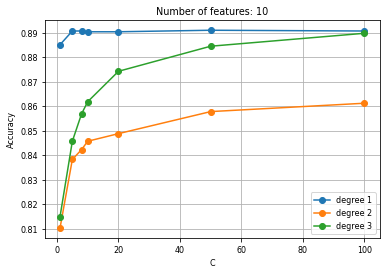

Degree:  1  C:  100  Max accuracy:  89.29
Degree:  2  C:  100  Max accuracy:  87.24
Degree:  3  C:  100  Max accuracy:  89.07


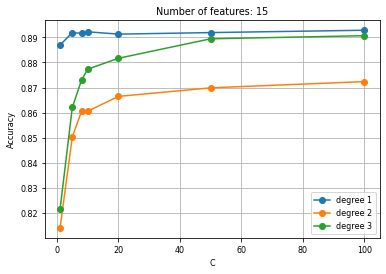

Degree:  1  C:  50  Max accuracy:  90.16
Degree:  2  C:  100  Max accuracy:  88.42
Degree:  3  C:  100  Max accuracy:  90.87


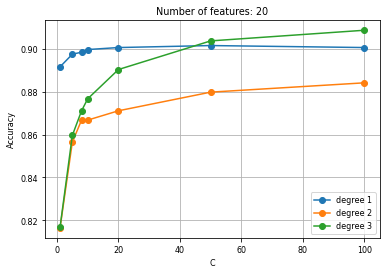

Degree:  1  C:  100  Max accuracy:  91.06
Degree:  2  C:  100  Max accuracy:  88.63
Degree:  3  C:  100  Max accuracy:  91.43


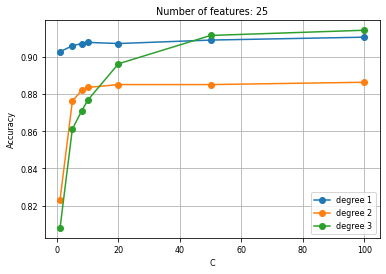

Degree:  1  C:  50  Max accuracy:  91.58
Degree:  2  C:  20  Max accuracy:  89.94
Degree:  3  C:  100  Max accuracy:  91.34


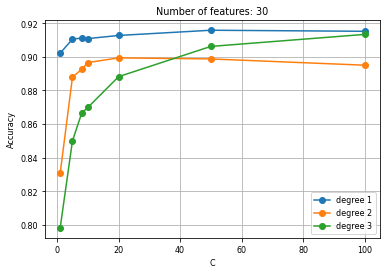

Degree:  1  C:  100  Max accuracy:  92.14
Degree:  2  C:  100  Max accuracy:  89.69
Degree:  3  C:  100  Max accuracy:  91.09


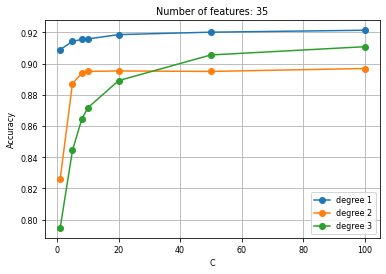

Degree:  1  C:  100  Max accuracy:  92.2
Degree:  2  C:  20  Max accuracy:  90.06
Degree:  3  C:  100  Max accuracy:  90.84


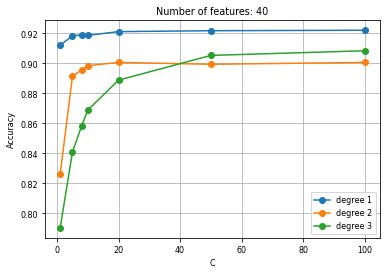

Degree:  1  C:  50  Max accuracy:  92.3
Degree:  2  C:  20  Max accuracy:  90.47
Degree:  3  C:  100  Max accuracy:  90.96


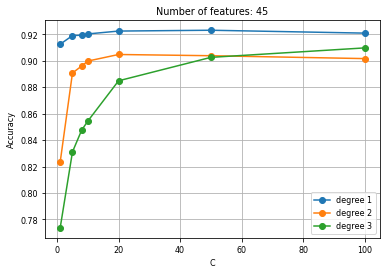

Degree:  1  C:  50  Max accuracy:  92.67
Degree:  2  C:  20  Max accuracy:  91.4
Degree:  3  C:  100  Max accuracy:  90.99


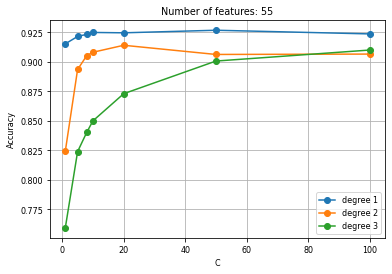

In [14]:
# Parameters 
C_rgl = [1, 5, 8, 10, 20, 50, 100]  # C parameter
degrees = [1, 2, 3]  # Degree parameter

# Number of features used to train
num_features = [5, 10, 15, 20, 25, 30, 35, 40, 45, 55]

# For each possible number of features
for f in num_features:
    # Get a matrix with only the top number_of_features to fit the model
    X_train_new = X_train.loc[:, inx[:f]]
    
    # For each possible degree
    for degree in degrees:
        accuracies = []  # Array used to save the mean accuracies values for different C parameter
        
        # For each possible c
        for i in C_rgl:
            # Create the model
            clf = SVC(kernel='poly', C=i, degree=degree)
            # Perform 4-Fold Cross Validation
            scores = cross_val_score(clf, X_train_new, y_train, cv=4, scoring="accuracy")
            # Save the mean accuracy value
            accuracies.append(scores.mean())
        
        # Print the best C parameter for this degree that returns the best accuracy
        print("Degree: ", degree, " C: ", C_rgl[np.argmax(accuracies)], " Max accuracy: " , round(np.max(accuracies)*100, 2)  )
        
        # Plot the accuracy values for each C parameter for this degree
        plt.plot(C_rgl, accuracies, marker="o" ,label=f"degree {degree}")
        
    plt.legend()
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.title(f"Number of features: {str(f)}") 
    plt.grid()
    plt.show()
     


## 2.2. Random Forest
Random forest is a learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. It consists of a large number of individual decision trees that operate as an ensemble, and each tree spits out a class prediction, and the class that has the most votes is the model's prediction.

Number of estimators  1000  Max accuracy:  87.76


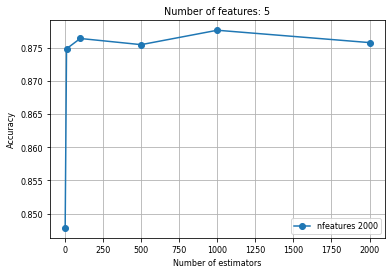

Number of estimators  1000  Max accuracy:  92.55


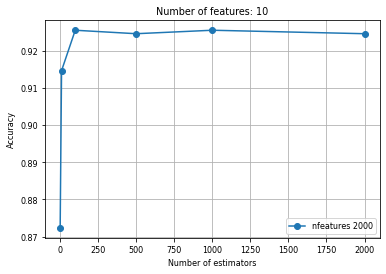

Number of estimators  500  Max accuracy:  93.11


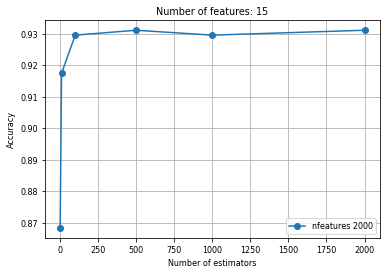

Number of estimators  500  Max accuracy:  93.82


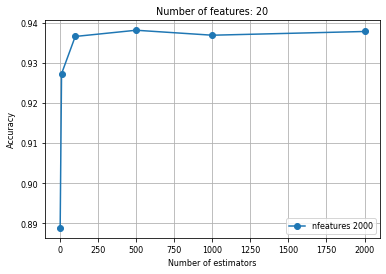

Number of estimators  2000  Max accuracy:  94.44


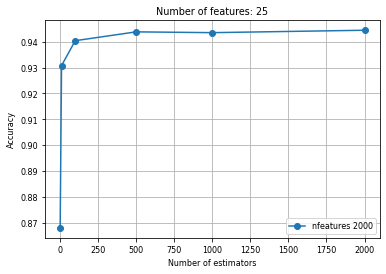

Number of estimators  1000  Max accuracy:  94.78


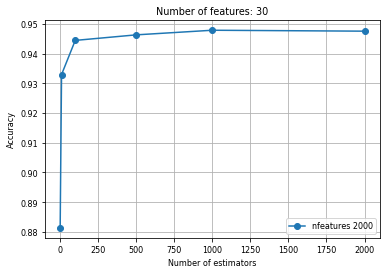

Number of estimators  2000  Max accuracy:  95.0


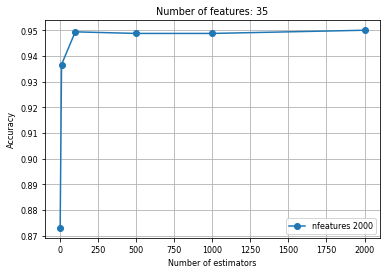

Number of estimators  2000  Max accuracy:  94.97


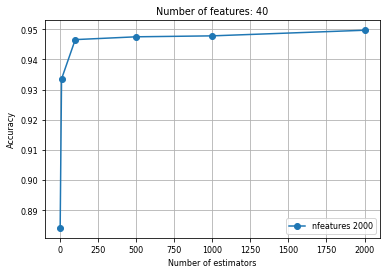

Number of estimators  2000  Max accuracy:  94.84


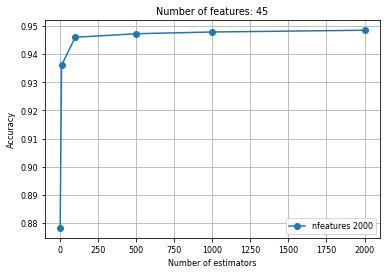

Number of estimators  2000  Max accuracy:  94.91


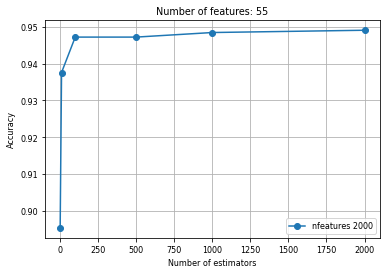

In [15]:
# Parameters 
number_of_estimators = [1, 10, 100, 500, 1000, 2000]  # Number of estimators/trees

# Number of features used to train
num_features = [5, 10, 15, 20, 25, 30, 35, 40, 45, 55]

# For each possible number of features
for f in num_features:
    # Get a matrix with only the top number_of_features to fit the model
    X_train_new = X_train.loc[:, inx[:f]]
    
    accuracies = []  # Array used to save the mean accuracies values for different C parameter
    # For each possible number of estimators/trees
    for i in number_of_estimators:
        # Create the model
        clf = RandomForestClassifier(n_estimators = i, random_state = 1) 
        # Perform 4-Fold Cross Validation
        scores = cross_val_score(clf, X_train_new, y_train, cv=4, scoring="accuracy")
        # Save the mean accuracy value
        accuracies.append(scores.mean())
        
    # Print the best number_of_estimators/trees parameter that returns the best accuracy
    print("Number of estimators ", number_of_estimators[np.argmax(accuracies)], " Max accuracy: " , round(np.max(accuracies)*100, 2) )
        
    # Plot the accuracy values for each number of estimators parameter
    plt.plot(number_of_estimators, accuracies, marker="o" ,label=f"nfeatures {i}")
    
    plt.legend()
    plt.xlabel("Number of estimators")
    plt.ylabel("Accuracy")
    plt.title(f"Number of features: {str(f)}") 
    plt.grid()
    plt.show()

## 2.3. Logistic Regression
Logistic Regression is a supervised machine learning algorithm that can be used to model the probability of a certain class. It is used when the data is linearly separable. Usually it is used for Binary classification models.

C:  10  Max accuracy:  85.28


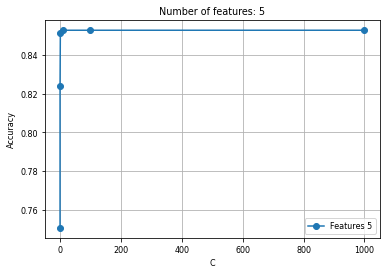

C:  100  Max accuracy:  88.51


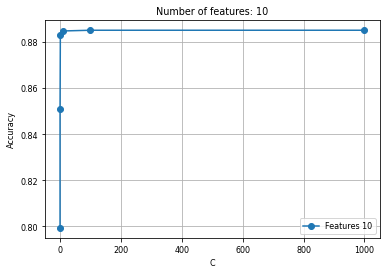

C:  10  Max accuracy:  89.07


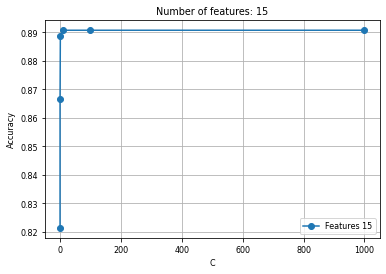

C:  100  Max accuracy:  89.04


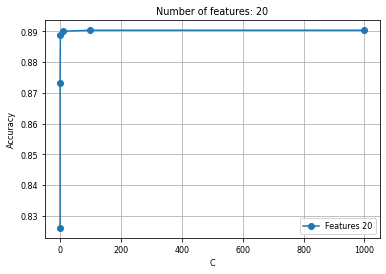

C:  1000  Max accuracy:  90.62


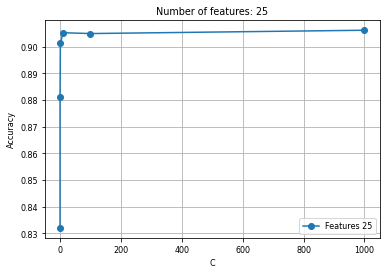

C:  10  Max accuracy:  90.87


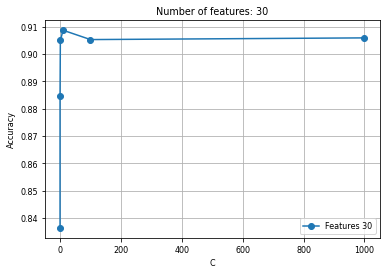

C:  100  Max accuracy:  91.96


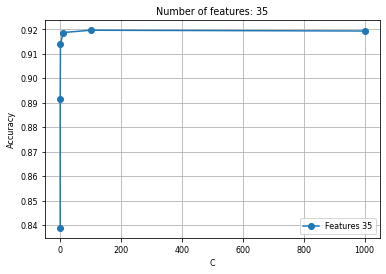

C:  10  Max accuracy:  91.77


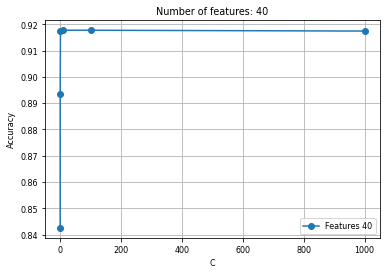

C:  1  Max accuracy:  91.74


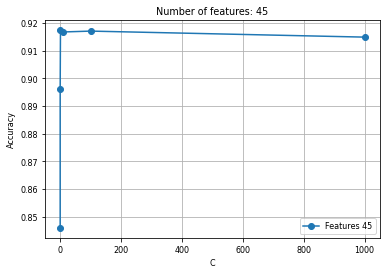

C:  10  Max accuracy:  91.93


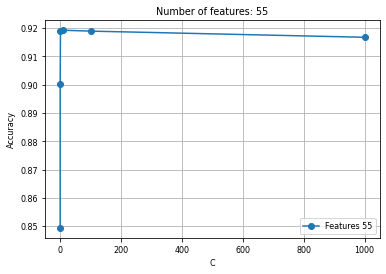

In [16]:
# Parameters 
C_rgl = [0.001, 0.01, 1, 10, 100, 1000]  # C parameter

# Number of features used to train
num_features = [5, 10, 15, 20, 25, 30, 35, 40, 45, 55]

# For each possible number of features
for f in num_features:
    # Get a matrix with only the top number_of_features to fit the model
    X_train_new = X_train.loc[:, inx[:f]]
    
    accuracies = []  # Array used to save the mean accuracies values for different C parameter
    # For each possible c
    for i in C_rgl:
        # Create the model
        clf = LogisticRegression(C=i, max_iter=1000)
        # Perform 4-Fold Cross Validation
        scores = cross_val_score(clf, X_train_new, y_train, cv=4, scoring="accuracy")
        # Save the mean accuracy value
        accuracies.append(scores.mean())
        
    # Print the best c parameter that returns the best accuracy
    print("C: ", C_rgl[np.argmax(accuracies)], " Max accuracy: ", round(np.max(accuracies)*100, 2))
        
    # Plot the accuracy values for each c parameter
    plt.plot(C_rgl, accuracies, marker="o" ,label=f"Features {f}")
    
    plt.legend()
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.title(f"Number of features: {str(f)}") 
    plt.grid()
    plt.show()

# 3. Test Model
Analyzing the results obtained in the previous section, we will now choose the best parameters to test the performance of our models using the test set.

Auxiliar function were developed to compute statistical metrics in order to evaluate the performance of the classifier.

In [17]:
def get_evaluation_metrics(y_test, y_predict):
    class_report = classification_report(y_test, y_predict, output_dict=True)
    
    accuracy = accuracy_score(y_test, y_predict)*100
    
    precision = precision_score(y_test, y_predict)*100
    
    recall = recall_score(y_test, y_predict)*100
    
    f1score = f1_score(y_test, y_predict)*100
    
    roc_area = roc_auc_score(y_test, y_predict)*100
    
    sensitivity = class_report["1"]["recall"]*100
    specificity = class_report["0"]["recall"]*100
    
    miss_rate = 100 - sensitivity
    
    matt_corr = matthews_corrcoef(y_test, y_predict)
    
    return accuracy, precision, recall, f1score, roc_area, sensitivity, specificity, miss_rate, matt_corr


In [18]:
def conf_matrix(real_values, predicted_values):
    # Create confusion matrix
    matrix = confusion_matrix(real_values, predicted_values, normalize='true')
    # Plot confusion matrix
    sns.heatmap(matrix, annot=True, cmap=plt.cm.Reds, xticklabels=["spam", "ham"], yticklabels=["spam", "ham"])
    plt.show()

## 3.1. SVM
Although there are other models with a slightly higher accuracy value, since they used more features, we ended up deciding to use a model with fewer features in order to reduce the complexity of the model. In other words, we prefer to choose a model that has an high accuracy, almost like the other ones, using fewer features, which allows us to reduce the complexity of the model.
We decided to use 35 features.<br>
The parameters we choose were:
- C = 50
- Degree = 1

SVM
Degree   C    Accuracy   Precision    Recall    F-measure   Roc area   Sensitivity   Specificity  Miss rate    MCC   
 1.00   50.00   92.03       91.48      88.14      89.78       91.37       88.14         94.60       11.86     0.83   


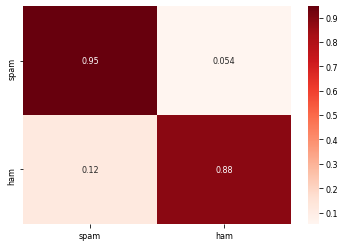

In [19]:
# Parameters of the best model obtained when training the model with diferent parameters
number_of_features = 35
C = 50
degree = 1

# Create a matrix for the data to train and to test with only the top number_of_features
X_train_new = X_train.loc[:, inx[:number_of_features]]
X_test_new = X_test.loc[:, inx[:number_of_features]]

# Create the model
svm_model = SVC(kernel='poly', C=C, degree=degree)
# Train the model using the training set
svm_model.fit(X_train_new, y_train)
# Predict the model for the test set
y_predict = svm_model.predict(X_test_new)

# Calculate metrics to evaluate the model
accuracy, precision, recall, f1score, roc_area, sensitivity, specificity, miss_rate, matt_corr = get_evaluation_metrics(y_test, y_predict)

print("SVM")
print("{:^7s} {:^4s} {:^10s} {:^11s} {:^10s} {:^12s} {:^9s} {:^13s} {:^13s} {:^9s} {:^9s}".format("Degree", "C", "Accuracy", "Precision", "Recall", "F-measure", "Roc area", "Sensitivity", "Specificity", "Miss rate", "MCC"))
print("{:^7.2f} {:^4.2f} {:^10.2f} {:^11.2f} {:^9.2f} {:^12.2f} {:^9.2f} {:^13.2f} {:^13.2f} {:^9.2f} {:^9.2f}"
.format(degree, C, round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1score, 2), round(roc_area, 2), round(sensitivity, 2), round(specificity, 2), miss_rate, matt_corr ))

conf_matrix(y_test, y_predict)

## 3.2. Random Forest
Analyzing the results obtained in section 2.2 and for similar reasons to the previous classifier, we also decided to choose the parameters taking into account the complexity that they would reflect in the model. 
That said, we ended up deciding to use 35 features. <br>
The following parameters were chosen:
- Number of estimators/tress = 1000

Random Forest
nEstimators  Accuracy   Precision   Recall    F-measure   Roc area   Sensitivity   Specificity  Miss rate    MCC   
    1000       95.00      94.60      92.70      93.64       94.61       92.70         96.52       7.30      0.90   


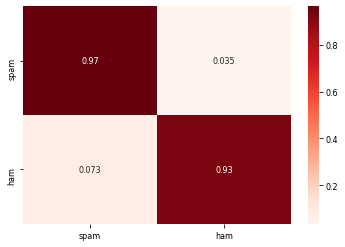

In [20]:
# Parameters of the best model obtained when training the model with diferent parameters
number_of_features = 35
n_estimators = 1000

# Create a matrix for the data to train and to test with only the top number_of_features
X_test_new = X_test.loc[:, inx[:number_of_features]]
X_train_new = X_train.loc[:, inx[:number_of_features]]

# Create the model
random_forest_model = RandomForestClassifier(n_estimators = n_estimators, random_state = 1) 
# Train the model using the training set
random_forest_model.fit(X_train_new, y_train)
# Predict the model for the test set
y_predict = random_forest_model.predict(X_test_new)

# Calculate metrics to evaluate the model
accuracy, precision, recall, f1score, roc_area, sensitivity, specificity, miss_rate, matt_corr = get_evaluation_metrics(y_test, y_predict)

print("Random Forest")
print("{:^12s} {:^9s} {:^11s} {:^9s} {:^12s} {:^9s} {:^13s} {:^13s} {:^9s} {:^9s}".format("nEstimators", "Accuracy", "Precision", "Recall", "F-measure", "Roc area", "Sensitivity", "Specificity", "Miss rate", "MCC"))
print("{:^12d} {:^9.2f} {:^11.2f} {:^9.2f} {:^12.2f} {:^9.2f} {:^13.2f} {:^13.2f} {:^9.2f} {:^9.2f}"
    .format(n_estimators, round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1score, 2), round(roc_area, 2), round(sensitivity, 2), round(specificity, 2), miss_rate, matt_corr ))
        
conf_matrix(y_test, y_predict)

## 3.3 Logistic Regression
Finally, regarding the Logistic Regression model, for the same reasons as before, since the accuracy values varied little as we increased the number of features after 30/35, we ended up also taking into account the complexity that would be reflected in the model. That said, we also decided to use 35 features, and the parameters we decided to use were:
- C = 1000

Logistic Regression
    C      Accuracy   Precision   Recall    F-measure   Roc area   Sensitivity   Specificity  Miss rate    MCC   
 1000.00     92.03      91.95      87.59      89.72       91.27       87.59         94.96       12.41     0.83   


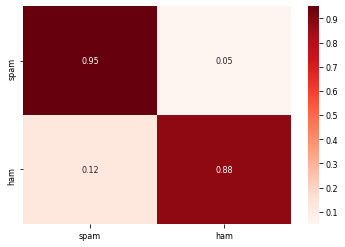

In [21]:
# Parameters of the best model obtained when training the model with diferent parameters
number_of_features = 35
C = 1000

# Create a matrix for the data to train and to test with only the top number_of_features
X_test_new = X_test.loc[:, inx[:number_of_features]]
X_train_new = X_train.loc[:, inx[:number_of_features]]

# Create the model
log_res_model = LogisticRegression(C=C, max_iter=1000)
# Train the model using the training set
log_res_model.fit(X_train_new, y_train)
# Predict the model for the test set
y_predict = log_res_model.predict(X_test_new)

# Calculate metrics to evaluate the model
accuracy, precision, recall, f1score, roc_area, sensitivity, specificity, miss_rate, matt_corr = get_evaluation_metrics(y_test, y_predict)

print("Logistic Regression")
print("{:^10s} {:^9s} {:^11s} {:^9s} {:^12s} {:^9s} {:^13s} {:^13s} {:^9s} {:^9s}".format("C", "Accuracy", "Precision", "Recall", "F-measure", "Roc area", "Sensitivity", "Specificity", "Miss rate", "MCC"))
print("{:^10.2f} {:^9.2f} {:^11.2f} {:^9.2f} {:^12.2f} {:^9.2f} {:^13.2f} {:^13.2f} {:^9.2f} {:^9.2f}"
    .format(C, round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1score, 2), round(roc_area, 2), round(sensitivity, 2), round(specificity, 2),  miss_rate, matt_corr ))

conf_matrix(y_test, y_predict)

# 4. Test with Enron Dataset
In this section we will test our three classifiers using a diferent dataset.<br>
We decided to perform this test in order to verify if the models we developed can have good results for other data sources.<br>
To perform this test we used Enron Dataset which is a dataset generated by the employees of Enron Corporation that contains E-mails classified as ham or spam. <br>
Since the Enron dataset actually has the content of the emails and not just the features like in SpambaseUCI, in order to extract the same features used by SpambaseUCI from the Enron dataset, we developed a python program called dataset_converter.py that will convert the e-mails content in the 57 features. In this way the data is represented in the same way in the two datasets. This program is available inside /Enron directory.

## 4.1. Read the data

In [22]:
enron_df = pd.read_csv("Enron/enron_dataset.csv", header=None)

# Get feature vector without the label
enron_X_test = enron_df.loc[:, :56]

# Get the vector with all labels
enron_y_test = enron_df[57]

## 4.2. Remove features that were removed in feature selection

In [23]:
enron_X_test = enron_X_test.drop(enron_X_test[removed_features], axis=1)
print("Removed Features: ", removed_features)

Removed Features:  [33, 39]


## 4.3. Scale the data using the StandardScaler created when training the data

In [24]:
scaled_features = scaler.transform(enron_X_test.values)
enron_X_test = pd.DataFrame(scaled_features, index=enron_X_test.index, columns=enron_X_test.columns)

## 4.4. SVM


SVM
 Accuracy   Precision    Recall    F-measure   Roc area   Sensitivity   Specificity  Miss rate    MCC   
  68.40       85.86      64.73      73.81       70.61       64.73         76.50       35.27     0.38   


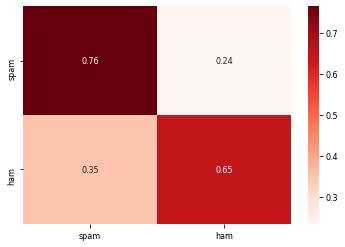

In [25]:
# Number of features used in SVM
number_of_features = 35

# Create a matrix for the data to test with only the top number_of_features
enron_X_test_new = enron_X_test.loc[:, inx[:number_of_features]]

# Predict the model for the examples from the enron dataset
y_predict = svm_model.predict(enron_X_test_new)

# Calculate metrics to evaluate the model
accuracy, precision, recall, f1score, roc_area, sensitivity, specificity, miss_rate, matt_corr = get_evaluation_metrics(enron_y_test, y_predict)

print("SVM")
print("{:^10s} {:^11s} {:^10s} {:^12s} {:^9s} {:^13s} {:^13s} {:^9s} {:^9s}".format("Accuracy", "Precision", "Recall", "F-measure", "Roc area", "Sensitivity", "Specificity", "Miss rate", "MCC"))
print("{:^10.2f} {:^11.2f} {:^9.2f} {:^12.2f} {:^9.2f} {:^13.2f} {:^13.2f} {:^9.2f} {:^9.2f}"
.format(round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1score, 2), round(roc_area, 2), round(sensitivity, 2), round(specificity, 2), miss_rate, matt_corr ))

conf_matrix(enron_y_test, y_predict)

## 4.5. Random Forest

Random Forest
Accuracy   Precision   Recall    F-measure   Roc area   Sensitivity   Specificity  Miss rate    MCC   
  50.87      93.26      30.81      46.32       62.95       30.81         95.09       69.19     0.29   


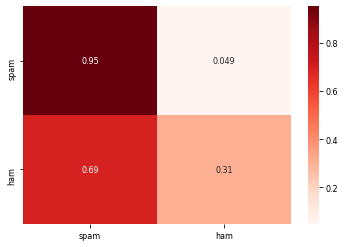

In [26]:
# Number of features used in Random Forest
number_of_features = 35

# Create a matrix for the data to test with only the top number_of_features
enron_X_test_new = enron_X_test.loc[:, inx[:number_of_features]]

# Predict the model for the examples from the enron dataset
y_predict = random_forest_model.predict(enron_X_test_new)

# Calculate metrics to evaluate the model
accuracy, precision, recall, f1score, roc_area, sensitivity, specificity, miss_rate, matt_corr = get_evaluation_metrics(enron_y_test, y_predict)

print("Random Forest")
print("{:^9s} {:^11s} {:^9s} {:^12s} {:^9s} {:^13s} {:^13s} {:^9s} {:^9s}".format("Accuracy", "Precision", "Recall", "F-measure", "Roc area", "Sensitivity", "Specificity", "Miss rate", "MCC"))
print("{:^9.2f} {:^11.2f} {:^9.2f} {:^12.2f} {:^9.2f} {:^13.2f} {:^13.2f} {:^9.2f} {:^9.2f}"
    .format(round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1score, 2), round(roc_area, 2), round(sensitivity, 2), round(specificity, 2), miss_rate, matt_corr ))
     
conf_matrix(enron_y_test, y_predict)

## 4.6. Logistic Regression

Logistic Regression
Accuracy   Precision   Recall    F-measure   Roc area   Sensitivity   Specificity  Miss rate    MCC   
  66.73      84.75      62.98      72.26       68.99       62.98         75.00       37.02     0.35   


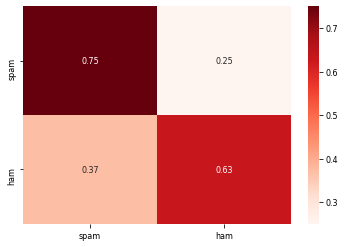

In [27]:
# Number of features used in Logistic Regression
number_of_features = 35

# Create a matrix for the data to test with only the top number_of_features
enron_X_test_new = enron_X_test.loc[:, inx[:number_of_features]]

# Predict the model for the examples from the enron dataset
y_predict = log_res_model.predict(enron_X_test_new)

# Calculate metrics to evaluate the model
accuracy, precision, recall, f1score, roc_area, sensitivity, specificity, miss_rate, matt_corr = get_evaluation_metrics(enron_y_test, y_predict)

print("Logistic Regression")
print("{:^9s} {:^11s} {:^9s} {:^12s} {:^9s} {:^13s} {:^13s} {:^9s} {:^9s}".format("Accuracy", "Precision", "Recall", "F-measure", "Roc area", "Sensitivity", "Specificity", "Miss rate", "MCC"))
print("{:^9.2f} {:^11.2f} {:^9.2f} {:^12.2f} {:^9.2f} {:^13.2f} {:^13.2f} {:^9.2f} {:^9.2f}"
    .format(round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1score, 2), round(roc_area, 2), round(sensitivity, 2), round(specificity, 2),  miss_rate, matt_corr ))

conf_matrix(enron_y_test, y_predict)

## 4.7. Results Analysis

Analyzing the results that we obtained for this test with the Enron Dataset, we were able to verify that the results are much worse than what we obtained previously. <br>This might happen due to the fact that the data from the SpamBaseUCI database that were used for training the models was very specific, i.e, the features that were taken from the initial data of the database may have not been the best, because, for example, there was the feature of the frequency of the word George, which in the SpamBaseUCI data may make sense but in a more general environment may not be a good feature to use. <br>
Another reason that may have helped to obtain this results is that mistakes may have occurred during the process of extraction of features performed in the Enron Dataset. However we have checked the results for some E-mail instances and they looked to be correct.